# Time-Series MIA Example 

In [1]:
import os, sys, yaml, numpy as np, matplotlib.pyplot as plt, torch, pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)  # <--- Puts it at the front of the path

from examples.mia.time_series_mia.utils.data_preparation import preprocess_dataset, get_dataloaders
from examples.mia.time_series_mia.utils.metrics import mse, smape, mae, nd
from examples.mia.time_series_mia.utils.model_preparation import create_trained_model_and_metadata, predict
from examples.mia.time_series_mia.utils.models.LSTM import LSTM
from examples.mia.time_series_mia.utils.models.TCN import TCN
from examples.mia.time_series_mia.utils.models.DLinear import DLinear
from examples.mia.time_series_mia.utils.models.NBeats import NBeats
from examples.mia.time_series_mia.utils.models.WaveNet import WaveNet
from examples.mia.time_series_mia.utils.models.Bromick import Bromick
from examples.mia.time_series_mia.utils.models.NHiTS import NHiTS
from examples.mia.time_series_mia.utils.set_seed import set_seed

from data_handler import IndividualizedInputHandler
from leakpro import LeakPro

In [2]:
audit_config_path = "audit.yaml"
train_config_path = "train_config.yaml"

# Load the yaml files
with open(audit_config_path, 'r') as file:
    audit_config = yaml.safe_load(file)

with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)

In [3]:
random_seed = train_config["run"]["random_seed"]
log_dir = train_config["run"]["log_dir"]

epochs = train_config["train"]["epochs"]
batch_size = train_config["train"]["batch_size"]
optimizer = train_config["train"]["optimizer"]
loss_fn = train_config["train"]["loss"]

lookback = train_config["data"]["lookback"]
horizon = train_config["data"]["horizon"]
num_individuals = train_config["data"]["num_individuals"]
train_fraction = train_config["data"]["f_train"]
val_fraction = train_config["data"].get("f_val", 0.0)
test_fraction = train_config["data"]["f_test"]
dataset_name = train_config["data"]["dataset"]
data_dir = train_config["data"]["data_dir"]
stride = train_config["data"]["stride"]
k_lead = train_config["data"]["k_lead"] # number of leading variables to use
num_time_steps = train_config["data"]["num_time_steps"] # number of time steps per individual
scaling = train_config["data"].get("scaling", "none") # none, standard, minmax, or robust

early_stopping = train_config["train"].get("early_stopping", False)
patience = train_config["train"].get("patience", 2)

if early_stopping and round(val_fraction * num_individuals) < 1:
    raise Exception("Early stopping applied but validation set is empty.")

In [4]:
# Get data loaders
path = os.path.join(os.getcwd(), data_dir)
target_data_path = audit_config["target"]["data_path"]
target_data_file = os.path.basename(target_data_path) # Only look at file name of target data path
target_data_file = os.path.splitext(target_data_file)[0]

if target_data_file != dataset_name:
    raise Exception(f"Received unknown dataset or mismatching target file: dataset={dataset_name}, target={target_data_path}.")

set_seed(random_seed) # Set seed before and after, to ensure same randomness if you process or dont process dataset (dataset already processed)
dataset = preprocess_dataset(dataset_name, path, lookback, horizon, num_individuals, stride, scaling, val_fraction, k_lead=k_lead, num_time_steps=num_time_steps)

set_seed(random_seed)
train_loader, val_loader, test_loader = get_dataloaders(dataset, train_fraction, test_fraction, batch_size=batch_size)

Save data to /home/edgelab/LeakPro/examples/mia/time_series_mia/../../../../data/ELD.pkl


In [5]:
num_train_individuals = len(train_loader.dataset) // dataset.samples_per_individual
num_test_individuals = len(test_loader.dataset) // dataset.samples_per_individual
print(f"Total {num_individuals} individuals whereof {num_train_individuals} train, {dataset.num_val_individuals} val, and {num_test_individuals} test")

Total 80 individuals whereof 16 train, 16 val, and 16 test


In [6]:
# Train the model
input_dim = dataset.input_dim
model_name = audit_config["target"]["model_class"]

if model_name == "LSTM":
    model = LSTM(input_dim, horizon)
elif model_name == "TCN":
    model = TCN(input_dim, horizon)
elif model_name == "DLinear":
    model = DLinear(input_dim, lookback, horizon)
elif model_name == "NBeats":
    model = NBeats(input_dim, lookback, horizon)
elif model_name == "WaveNet":
    model = WaveNet(input_dim, horizon)
elif model_name == "NHiTS":
    model = NHiTS(input_dim, lookback, horizon)
elif model_name == "Bromick" or model_name == "Bhowmick":
    model = Bromick(input_dim, horizon)
else:
    raise NotImplementedError()

train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs, optimizer, loss_fn, dataset_name, val_loader, early_stopping, patience)

Training Progress:   8%|▊         | 4/50 [01:35<18:22, 23.96s/it]

Training stopped early at epoch 5.
Best weights restored.


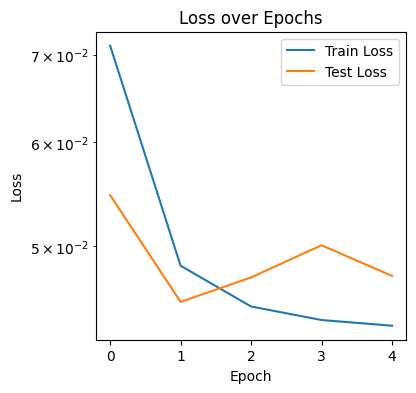

In [7]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

### Plot metrics for final target model

In [8]:
# Print metrics on final model, unscaled vs scaled, train and test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = dataset.scaler

train = predict(model, train_loader, device, scaler, original_scale=False)
test  = predict(model, test_loader, device, scaler, original_scale=False)
unscaled_train = predict(model, train_loader, device, scaler, original_scale=True)
unscaled_test  = predict(model, test_loader, device, scaler, original_scale=True)

metrics, names = [mse, mae, smape, nd], ["MSE", "MAE", "SMAPE", "ND"]

if val_loader:
    val  = predict(model, val_loader, device, scaler, original_scale=False)
    unscaled_val = predict(model, val_loader, device, scaler, original_scale=True)
    values = [[m(*p) for m in metrics] for p in [train, test, val, unscaled_train, unscaled_test, unscaled_val]]
    print(pd.DataFrame(values, columns=names, index=["Train", "Test", "Val", "Unscaled train", "Unscaled test", "Unscaled val"]))
else:
    values = [[m(*p) for m in metrics] for p in [train, test, unscaled_train, unscaled_test]]
    print(pd.DataFrame(values, columns=names, index=["Train", "Test", "Unscaled train", "Unscaled test"]))

                         MSE         MAE     SMAPE        ND
Train           6.026682e-03    0.042299  0.099623  0.089930
Test            1.310243e-02    0.047490  0.131973  0.100573
Val             2.778122e+00    0.441571  0.074538  0.099828
Unscaled train  1.682953e+04   70.685089  0.030027  0.054179
Unscaled test   3.658854e+04   79.358688  0.037090  0.066830
Unscaled val    7.757924e+06  737.898987  0.048111  0.093946


### Plotting sample predictions

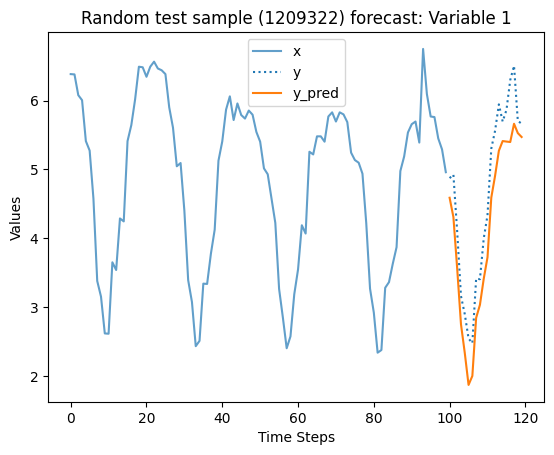

In [9]:
# Get random sample (re-execute for new one)
indices = test_loader.dataset.indices
random_sample_idx = np.random.choice(indices)
x = dataset.data[random_sample_idx,:,:].to(device)
y = dataset.targets[random_sample_idx,:,:]
y_pred = model(x.unsqueeze(0)).detach().squeeze(0)

# Time axis
time_x = np.arange(lookback)
time_y = np.arange(lookback, lookback + horizon)

for i in range(y.shape[-1]):  # plot forecast for each variable in the series
    plt.plot(time_x, x[:, i].cpu().numpy(), label='x', alpha=0.7)  # lookback
    plt.plot(time_y, y[:, i], label='y', color='C0', linestyle='dotted')  # true horizon
    plt.plot(time_y, y_pred[:, i].cpu().numpy(), label='y_pred', color='C1')  # prediction

    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.title(f"Random test sample ({random_sample_idx}) forecast: Variable {i+1}")
    plt.show()

### Running MIA

In [ ]:
# Prepare leakpro object
leakpro = LeakPro(IndividualizedInputHandler, audit_config_path)

# Run the audit 
mia_results = leakpro.run_audit(create_pdf=True, use_optuna=False)

ValidationError: 1 validation error for LeakProConfig
audit.attack_list
  Input should be a valid list [type=list_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.10/v/list_type